In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Load the dataset
transform = transforms.Compose([
    transforms.ToTensor()  # Automatically converts to tensor and scales to [0, 1]
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [14]:
# Define the model
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = FashionMNISTModel()

if torch.cuda.is_available():
    model = model.to('cuda')
    

# Define the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [15]:
# Train the model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        if torch.cuda.is_available():
            X = X.to('cuda')
            y = y.to('cuda')
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Training process
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_function, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.291573  [    0/60000]
loss: 0.652354  [ 6400/60000]
loss: 0.478874  [12800/60000]
loss: 0.349336  [19200/60000]
loss: 0.510502  [25600/60000]
loss: 0.729749  [32000/60000]
loss: 0.532373  [38400/60000]
loss: 0.374619  [44800/60000]
loss: 0.330385  [51200/60000]
loss: 0.434690  [57600/60000]
Epoch 2
-------------------------------
loss: 0.257837  [    0/60000]
loss: 0.396995  [ 6400/60000]
loss: 0.262595  [12800/60000]
loss: 0.258004  [19200/60000]
loss: 0.367092  [25600/60000]
loss: 0.317387  [32000/60000]
loss: 0.512914  [38400/60000]
loss: 0.336108  [44800/60000]
loss: 0.302062  [51200/60000]
loss: 0.334314  [57600/60000]
Epoch 3
-------------------------------
loss: 0.361124  [    0/60000]
loss: 0.395251  [ 6400/60000]
loss: 0.356017  [12800/60000]
loss: 0.335511  [19200/60000]
loss: 0.495257  [25600/60000]
loss: 0.459716  [32000/60000]
loss: 0.650583  [38400/60000]
loss: 0.351644  [44800/60000]
loss: 0.257056  [51200/60000]
loss: 0.24

In [16]:
# Function to test the model
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Set the model to evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            if torch.cuda.is_available():
                X, y = X.to('cuda'), y.to('cuda')
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Evaluate the model
test(test_loader, model)


Test Error: 
 Accuracy: 86.8%, Avg loss: 0.361934 



In [21]:
# CHECK SINGLE PREDICTION AND PLOT
import matplotlib.pyplot as plt

def predict_single_image(image, label, model):
    # Set the model to evaluation mode
    model.eval()

    # Image needs to be unsqueezed as the model expects a batch dimension
    image = image.unsqueeze(0)

    with torch.no_grad():
        if torch.cuda.is_available():
            image = image.to('cuda')
        prediction = model(image)
        print(prediction)
        predicted_label = prediction.argmax(1).item()

    # Display the image and predictions
    plt.imshow(image.to('cpu').squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted_label}, Actual: {label}')
    plt.show()

    return predicted_label

tensor([[ -1.1075, -10.0689,  -4.1681,  -7.0006, -11.1615, -16.0137,  -0.4279,
         -19.7766,  -6.6250, -18.6619]], device='cuda:0')


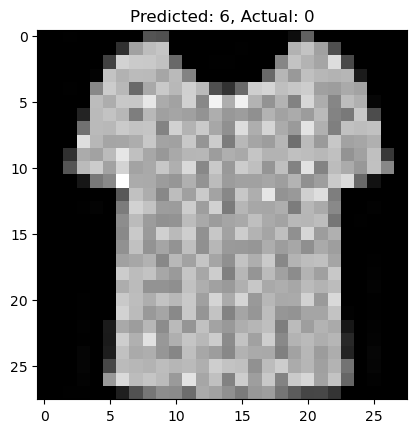

The model predicted 6, and the actual label is 0.


In [22]:
# Choose an image from the test set
image, label = test_dataset[1000]  # Change index to test different images

# Predict the class for the chosen image
predicted_label = predict_single_image(image, label, model)
print(f"The model predicted {predicted_label}, and the actual label is {label}.")

In [26]:
# EARLY STOPPING VERSION
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the dataset
transform = transforms.Compose([
    transforms.ToTensor()  # Automatically converts to tensor and scales to [0, 1]
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = FashionMNISTModel()
if torch.cuda.is_available():
    model = model.to('cuda')

# Define the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

# Function to calculate accuracy
def get_accuracy(pred, labels):
    _, predictions = torch.max(pred, 1)
    correct = (predictions == labels).float().sum()
    accuracy = correct / labels.shape[0]
    return accuracy

# Train the model with accuracy reporting
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, total_accuracy = 0, 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        if torch.cuda.is_available():
            X, y = X.to('cuda'), y.to('cuda')
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        accuracy = get_accuracy(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

        if batch % 100 == 0:
            current = batch * len(X)
            avg_loss = total_loss / (batch + 1)
            avg_accuracy = total_accuracy / (batch + 1) * 100
            print(f"Batch {batch}, Loss: {avg_loss:>7f}, Accuracy: {avg_accuracy:>0.2f}% [{current:>5d}/{size:>5d}]")

    # Early stopping condition
    if avg_accuracy >= 95:
        print("Reached 95% accuracy, stopping training.")
        return True  # Stop training

# Training process
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    if train(train_loader, model, loss_function, optimizer):  # Check for the early stopping signal
        print("Early stopping triggered.")
        break
print("Done!")


Epoch 1
-------------------------------
Batch 0, Loss: 2.314224, Accuracy: 23.44% [    0/60000]
Batch 100, Loss: 0.972206, Accuracy: 68.30% [ 6400/60000]
Batch 200, Loss: 0.780996, Accuracy: 73.87% [12800/60000]
Batch 300, Loss: 0.698478, Accuracy: 76.42% [19200/60000]
Batch 400, Loss: 0.648113, Accuracy: 78.03% [25600/60000]
Batch 500, Loss: 0.617895, Accuracy: 78.89% [32000/60000]
Batch 600, Loss: 0.596323, Accuracy: 79.52% [38400/60000]
Batch 700, Loss: 0.576943, Accuracy: 80.20% [44800/60000]
Batch 800, Loss: 0.561502, Accuracy: 80.70% [51200/60000]
Batch 900, Loss: 0.550031, Accuracy: 81.10% [57600/60000]
Epoch 2
-------------------------------
Batch 0, Loss: 0.450240, Accuracy: 85.94% [    0/60000]
Batch 100, Loss: 0.423368, Accuracy: 85.21% [ 6400/60000]
Batch 200, Loss: 0.421220, Accuracy: 85.15% [12800/60000]
Batch 300, Loss: 0.416529, Accuracy: 85.39% [19200/60000]
Batch 400, Loss: 0.417957, Accuracy: 85.29% [25600/60000]
Batch 500, Loss: 0.417394, Accuracy: 85.20% [32000/600